In [1]:
import pandas as pd
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 대안데이터 불러오기
alter_raw = pd.DataFrame()

# 대안데이터 7월~11월 합치기
for i in range(7,12):
    data = pd.read_csv(f'../alternative_data/대안{i}.csv', encoding='cp949')
    alter_raw = pd.concat([alter_raw, data], axis=0)

alter_raw.shape

(50880, 143)

In [2]:
alter_data = copy.deepcopy(alter_raw)
alter_data.head()

,행정동코드,자치구,행정동,성별,연령대,총인구수,1인가구수,야간상주지 변경 미추정 인구 수,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 25%",...,배달_브랜드 서비스 사용 미추정 인구수,배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 25%","배달_브랜드 서비스 사용일수: 4분위수, 50%","배달_브랜드 서비스 사용일수: 4분위수, 75%",배달_식재료 서비스 사용 미추정 인구수,배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 25%","배달_식재료 서비스 사용일수: 4분위수, 50%","배달_식재료 서비스 사용일수: 4분위수, 75%"
0,1101053,종로구,사직동,1,20,206,64,0,2.5,2,...,181,3.5,1.7,3.3,6.7,204,1.7,1.7,1.7,1.7
1,1101053,종로구,사직동,1,25,341,115,0,2.1,1,...,285,2.8,1.7,1.7,3.3,338,1.7,1.7,1.7,1.7
2,1101053,종로구,사직동,1,30,402,132,0,1.9,1,...,348,3.3,1.7,1.7,5.0,396,1.7,1.7,1.7,1.7
3,1101053,종로구,사직동,1,35,408,125,0,1.9,1,...,344,3.2,1.7,3.3,3.3,400,1.7,1.7,1.7,1.7
4,1101053,종로구,사직동,1,40,399,99,0,1.7,1,...,355,3.0,1.7,1.7,5.0,389,1.7,1.7,1.7,1.7


In [3]:
# 1인가구 비율 산정하여 점수화에 활용
alter_data['1인가구 비율'] = round(alter_data['1인가구수'].str.replace(',','').astype(int) / alter_data['총인구수'].str.replace(',','').astype(int),2)

# 사용하지 않을 컬럼 제거
words_to_drop = ['행정동코드','자치구','행정동','1인가구수', '4분위수, 25%', '4분위수, 75%', 
                 '출근', '근무시간', '카카오톡','통화','문자','이동','집 추정','미추정','인구']

# 
pattern = '|'.join(words_to_drop)
alter_data_clean = alter_data.loc[:, ~alter_data.columns.str.contains(pattern)]
alter_data_clean.head()

,성별,연령대,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",...,"유튜브 사용일수: 4분위수, 50%",넷플릭스 사용일수,"넷플릭스 사용일수: 4분위수, 50%",배달 서비스 사용일수,"배달 서비스 사용일수: 4분위수, 50%",배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 50%",배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율
0,1,20,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,...,0.4,-0.2,-0.2,11.0,8.3,3.5,3.3,1.7,1.7,0.31
1,1,25,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,...,0.3,-0.2,-0.2,13.6,10.0,2.8,1.7,1.7,1.7,0.34
2,1,30,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,...,0.3,-0.3,-0.5,13.7,11.7,3.3,1.7,1.7,1.7,0.33
3,1,35,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,...,0.2,-0.3,-0.4,13.8,10.0,3.2,3.3,1.7,1.7,0.31
4,1,40,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,...,0.1,-0.3,-0.5,14.3,10.0,3.0,1.7,1.7,1.7,0.25


In [4]:
# alter_data_clean을 복사본으로 생성
alter_data_clean = alter_data_clean.copy()

# 연체여부 데이터 부족으로 평균 이상, 평균이하에 따라 여부 판단
alter_mean = alter_data_clean['최근 3개월 내 요금 연체 비율'].mean()
alter_data_clean.loc[:, '최근 3개월 내 요금 연체 비율'] = alter_data_clean['최근 3개월 내 요금 연체 비율'].apply(lambda x: 1 if x > alter_mean else 0)

# 컬럼 이름 변경
alter_data_clean.rename(columns={'최근 3개월 내 요금 연체 비율': '연체여부'}, inplace=True)

# 연체여부 비율 확인
alter_data_clean['연체여부'].value_counts()

0    27829
1    23051
Name: 연체여부, dtype: int64

In [5]:
# 성별 원핫 인코딩
gender = pd.get_dummies(alter_data_clean['성별'])
alter_data_clean = alter_data_clean.drop('성별', axis=1)
alter_data_clean = pd.concat([alter_data_clean,gender], axis=1)

alter_data_clean.rename(columns={1: '남성',2:'여성'}, inplace=True)
alter_data_clean.head()

,연령대,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",연체여부,...,"넷플릭스 사용일수: 4분위수, 50%",배달 서비스 사용일수,"배달 서비스 사용일수: 4분위수, 50%",배달_브랜드 서비스 사용일수,"배달_브랜드 서비스 사용일수: 4분위수, 50%",배달_식재료 서비스 사용일수,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율,남성,여성
0,20,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0,...,-0.2,11.0,8.3,3.5,3.3,1.7,1.7,0.31,1,0
1,25,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,1,...,-0.2,13.6,10.0,2.8,1.7,1.7,1.7,0.34,1,0
2,30,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,1,...,-0.5,13.7,11.7,3.3,1.7,1.7,1.7,0.33,1,0
3,35,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,1,...,-0.4,13.8,10.0,3.2,3.3,1.7,1.7,0.31,1,0
4,40,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0,...,-0.5,14.3,10.0,3.0,1.7,1.7,1.7,0.25,1,0


In [6]:
# 나이 원핫 인코딩
alter_data_clean['연령대'] = alter_data_clean['연령대'].astype(str).str[0].astype(int)
alter_data_clean['연령대'].head()

age_df = pd.get_dummies(alter_data_clean['연령대'])
alter_data_clean = alter_data_clean.drop('연령대', axis=1)
alter_data_clean = pd.concat([alter_data_clean,age_df], axis=1)

age_keys = [2,3,4,5,6,7]
age_values = ['20대','30대','40대','50대','60대','70대']

alter_data_clean.rename(columns=dict(zip(age_keys,age_values)), inplace=True)
alter_data_clean.head()

,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",연체여부,SNS 사용횟수,...,"배달_식재료 서비스 사용일수: 4분위수, 50%",1인가구 비율,남성,여성,20대,30대,40대,50대,60대,70대
0,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0,0.0,...,1.7,0.31,1,0,1,0,0,0,0,0
1,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,1,0.2,...,1.7,0.34,1,0,1,0,0,0,0,0
2,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,1,0.2,...,1.7,0.33,1,0,0,1,0,0,0,0
3,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,1,0.1,...,1.7,0.31,1,0,0,1,0,0,0,0
4,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0,0.1,...,1.7,0.25,1,0,0,0,1,0,0,0


In [7]:
# 칼럼 순서조정(평균, 중간값 나누기 위해서)
for i in ['연체여부','1인가구 비율']:
    column_move = alter_data_clean.pop(i)
    alter_data_clean.insert(len(alter_data_clean.columns), i, column_move)
alter_data_clean.head()

,야간상주지 변경횟수 평균,"야간상주지 변경횟수: 4분위수, 50%",주간상주지 변경횟수 평균,"주간상주지 변경횟수: 4분위수, 50%",소액결재 사용횟수 평균,"소액결재 사용횟수: 4분위수, 50%",소액결재 사용금액 평균,"소액결재 사용금액: 4분위수, 50%",SNS 사용횟수,"SNS 사용횟수: 4분위수, 50%",...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2.5,2,2.5,2,0.0,0.0,5944.4,3666.7,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0.31
1,2.1,2,2.2,2,2.6,3.3,7777.8,11000.0,0.2,0.2,...,1,0,1,0,0,0,0,0,1,0.34
2,1.9,2,1.8,1,2.8,3.3,5854.2,5000.0,0.2,0.2,...,1,0,0,1,0,0,0,0,1,0.33
3,1.9,2,1.7,1,1.9,1.7,6286.7,5666.7,0.1,0.1,...,1,0,0,1,0,0,0,0,1,0.31
4,1.7,1,1.7,1,2.8,3.3,6098.0,6333.3,0.1,0.1,...,1,0,0,0,1,0,0,0,0,0.25


In [8]:
# 중간값 컬럼, 평균값 컬럼 나누기
alter_avg = pd.DataFrame()
alter_mid = pd.DataFrame()

# 중간값, 평균 데이터 분리
for i in range(0, alter_data_clean.shape[1] -10, 2):
    alter_avg[alter_data_clean.columns[i]] = alter_data_clean.iloc[:, i]
    alter_mid[alter_data_clean.columns[i+1]] = alter_data_clean.iloc[:, i+1]

# 기존 데이터와 사분위 50% 차이값 데이터 결합
alter_mid = pd.concat((alter_mid, alter_data_clean.iloc[:,-10:]),axis=1)
alter_avg = pd.concat((alter_avg, alter_data_clean.iloc[:,-10:]),axis=1)

display(alter_avg.head())
display(alter_mid.head())

,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,SNS 사용횟수,데이터 사용량,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2.5,2.5,0.0,5944.4,0.0,21.4,56.8,141.3,123.5,56.6,...,1,0,1,0,0,0,0,0,0,0.31
1,2.1,2.2,2.6,7777.8,0.2,19.8,41.3,187.9,174.5,56.0,...,1,0,1,0,0,0,0,0,1,0.34
2,1.9,1.8,2.8,5854.2,0.2,17.1,34.0,188.9,181.4,55.9,...,1,0,0,1,0,0,0,0,1,0.33
3,1.9,1.7,1.9,6286.7,0.1,13.6,33.2,184.8,189.6,54.8,...,1,0,0,1,0,0,0,0,1,0.31
4,1.7,1.7,2.8,6098.0,0.1,11.2,22.5,189.8,199.2,55.2,...,1,0,0,0,1,0,0,0,0,0.25


,"야간상주지 변경횟수: 4분위수, 50%","주간상주지 변경횟수: 4분위수, 50%","소액결재 사용횟수: 4분위수, 50%","소액결재 사용금액: 4분위수, 50%","SNS 사용횟수: 4분위수, 50%","데이터 사용량: 4분위수, 50%","게임 서비스 사용일수: 4분위수, 50%","금융 서비스 사용일수: 4분위수, 50%","쇼핑 서비스 사용일수: 4분위수, 50%","동영상/방송 서비스 사용일수: 4분위수, 50%",...,남성,여성,20대,30대,40대,50대,60대,70대,연체여부,1인가구 비율
0,2,2,0.0,3666.7,0.0,16.4,50.0,136.7,106.7,43.3,...,1,0,1,0,0,0,0,0,0,0.31
1,2,2,3.3,11000.0,0.2,16.5,25.0,176.7,161.7,53.3,...,1,0,1,0,0,0,0,0,1,0.34
2,2,1,3.3,5000.0,0.2,12.2,21.7,186.7,166.7,51.7,...,1,0,0,1,0,0,0,0,1,0.33
3,2,1,1.7,5666.7,0.1,8.7,16.7,160.0,153.3,46.7,...,1,0,0,1,0,0,0,0,1,0.31
4,1,1,3.3,6333.3,0.1,6.6,10.0,185.0,178.3,50.0,...,1,0,0,0,1,0,0,0,0,0.25


In [9]:
alter_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50880 entries, 0 to 10175
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   야간상주지 변경횟수 평균    50880 non-null  float64
 1   주간상주지 변경횟수 평균    50880 non-null  float64
 2   소액결재 사용횟수 평균     50880 non-null  float64
 3   소액결재 사용금액 평균     50880 non-null  float64
 4   SNS 사용횟수         50880 non-null  float64
 5   데이터 사용량          50880 non-null  float64
 6   게임 서비스 사용일수      50880 non-null  float64
 7   금융 서비스 사용일수      50880 non-null  float64
 8   쇼핑 서비스 사용일수      50880 non-null  float64
 9   동영상/방송 서비스 사용일수  50880 non-null  float64
 10  유튜브 사용일수         50880 non-null  float64
 11  넷플릭스 사용일수        50880 non-null  float64
 12  배달 서비스 사용일수      50880 non-null  float64
 13  배달_브랜드 서비스 사용일수  50880 non-null  float64
 14  배달_식재료 서비스 사용일수  50880 non-null  float64
 15  남성               50880 non-null  uint8  
 16  여성               50880 non-null  uint8  
 17  20대         

In [11]:
alter_avg.corr()['연체여부'].sort_values(ascending=False)

연체여부               1.000000
데이터 사용량            0.484264
동영상/방송 서비스 사용일수    0.468946
게임 서비스 사용일수        0.440614
SNS 사용횟수           0.436468
배달 서비스 사용일수        0.434383
유튜브 사용일수           0.434364
주간상주지 변경횟수 평균      0.423369
금융 서비스 사용일수        0.422127
넷플릭스 사용일수          0.393302
쇼핑 서비스 사용일수        0.377090
소액결재 사용금액 평균       0.311503
야간상주지 변경횟수 평균      0.274868
20대                0.232563
배달_브랜드 서비스 사용일수    0.208086
소액결재 사용횟수 평균       0.203025
30대                0.197813
배달_식재료 서비스 사용일수    0.179026
남성                 0.132148
1인가구 비율            0.116431
40대                0.063689
50대                0.018452
여성                -0.132148
60대               -0.149468
70대               -0.363049
Name: 연체여부, dtype: float64

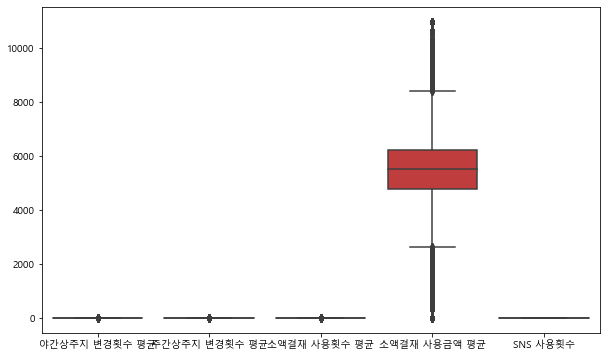

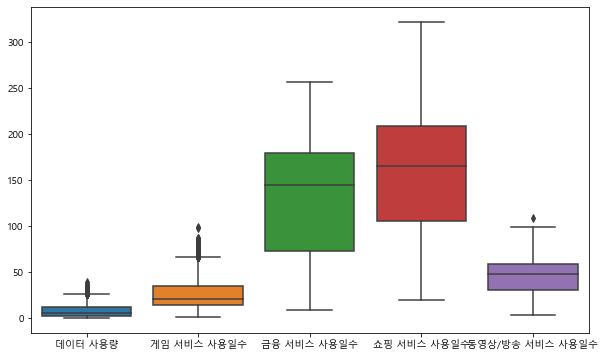

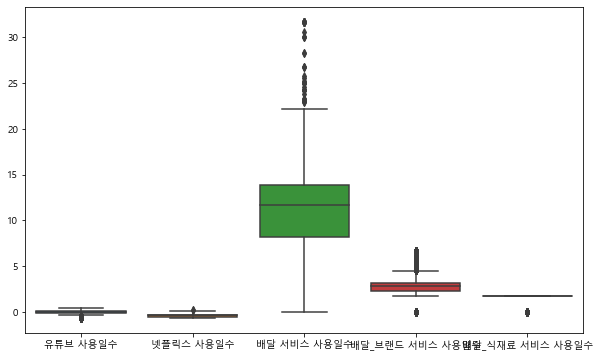

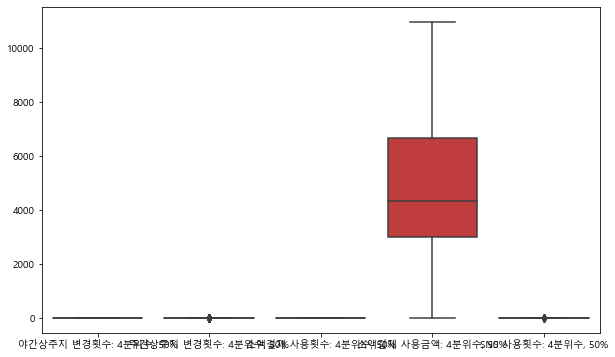

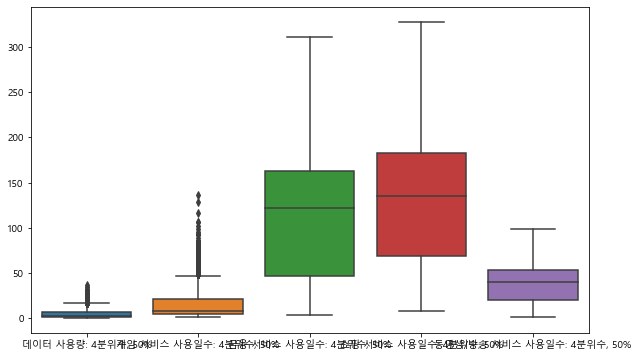

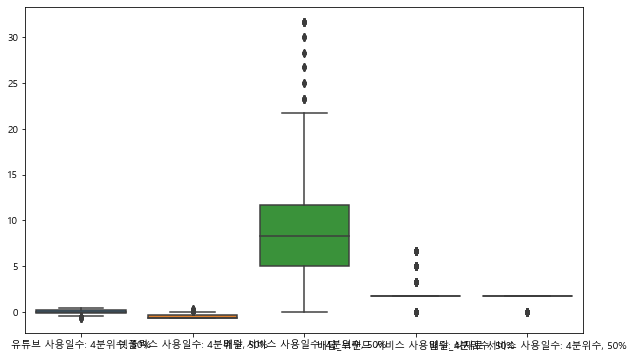

In [12]:
# 아웃라이어 확인 박스플롯
def make_box(data):
    for i in range(3):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data.iloc[:, i*5:(i+1)*5])
        plt.show()

make_box(alter_avg)
make_box(alter_mid)


In [13]:
# 아웃라이어 제거
def remove_outliers(df):
    df_out = df.iloc[:,:15]
    Q1 = df_out.quantile(0.25)
    Q3 = df_out.quantile(0.75)
    IQR = Q3 - Q1
    filter =  ~((df_out < (Q1 - 1.5 * IQR)) | (df_out > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[filter]

alter_avg_cleaned = remove_outliers(alter_avg)
alter_mid_cleaned = remove_outliers(alter_mid)

alter_avg_cleaned.shape, alter_mid_cleaned.shape

((34819, 25), (28330, 25))

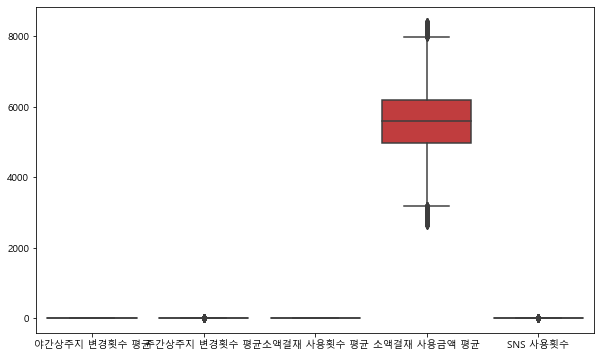

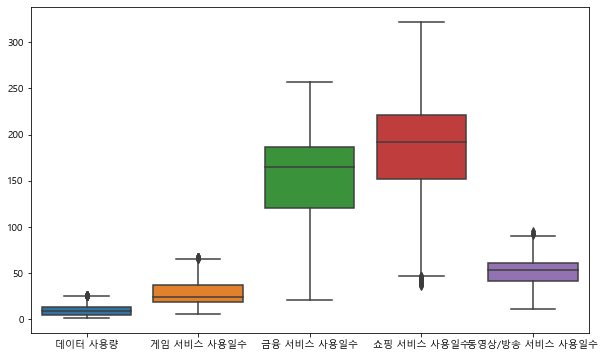

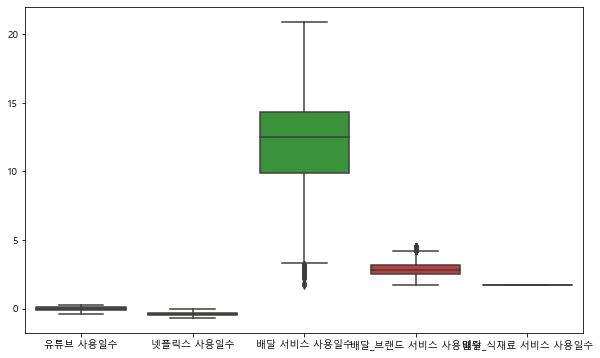

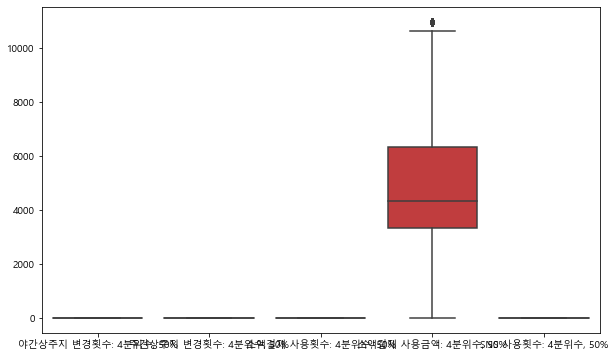

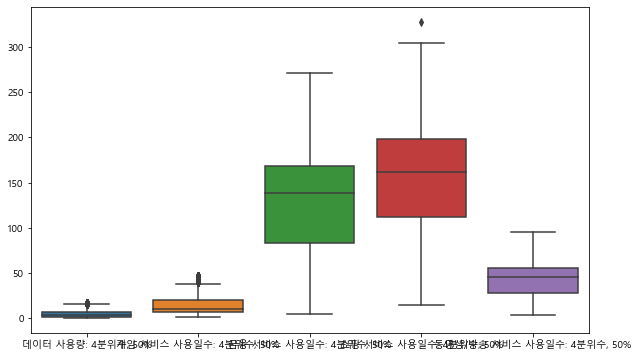

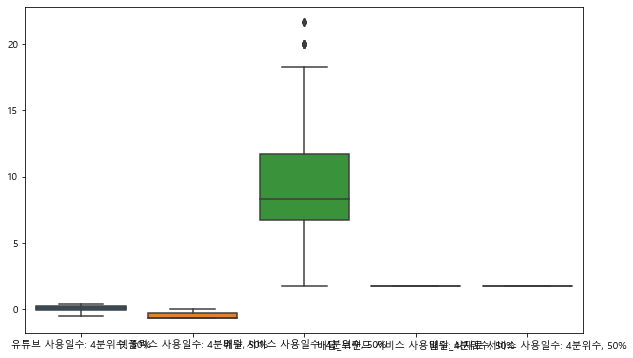

In [14]:
# 아웃라이어 제거 확인
make_box(alter_avg_cleaned)
make_box(alter_mid_cleaned)

In [15]:
# 모델학습 핵심 지표 매핑
alter_avg_mapping = {
    '소비 빈도 및 활동성': [
        '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '소액결재 사용횟수 평균', 
        'SNS 사용횟수', '게임 서비스 사용일수', '쇼핑 서비스 사용일수'
    ],
    '소비 금액 및 규모': [
        '소액결재 사용금액 평균', '데이터 사용량', '유튜브 사용일수', 
        '넷플릭스 사용일수', '배달 서비스 사용일수'
    ],
    '연체 가능성 및 신용 리스크': ['1인가구 비율'
    ],
    '서비스 이용 다양성': [
        '금융 서비스 사용일수', '동영상/방송 서비스 사용일수', 
        '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수'
    ]
}

alter_mid_mapping = {
    '소비 빈도 및 활동성': [
        '야간상주지 변경횟수: 4분위수, 50%', '주간상주지 변경횟수: 4분위수, 50%', 
        '소액결재 사용횟수: 4분위수, 50%', 'SNS 사용횟수: 4분위수, 50%', 
        '게임 서비스 사용일수: 4분위수, 50%', '쇼핑 서비스 사용일수: 4분위수, 50%'
    ],
    '소비 금액 및 규모': [
        '소액결재 사용금액: 4분위수, 50%', '데이터 사용량: 4분위수, 50%', 
        '유튜브 사용일수: 4분위수, 50%', '넷플릭스 사용일수: 4분위수, 50%', 
        '배달 서비스 사용일수: 4분위수, 50%'
    ],
    '연체 가능성 및 신용 리스크': ['1인가구 비율'],
    '서비스 이용 다양성': [
        '금융 서비스 사용일수: 4분위수, 50%', '동영상/방송 서비스 사용일수: 4분위수, 50%', 
        '배달_브랜드 서비스 사용일수: 4분위수, 50%', '배달_식재료 서비스 사용일수: 4분위수, 50%'
    ]
}


In [16]:
# # 정규화(X)
# # 핵심 지표 생성 함수
# def create_core_features(data, mapping):
#     core_features = {}
#     for feature_name, columns in mapping.items():
#         core_features[feature_name] = data[columns].mean(axis=1)  # 평균값으로 통합
#     return pd.DataFrame(core_features)

# alter_avg_index = create_core_features(alter_avg_cleaned, alter_avg_mapping)
# alter_mid_index = create_core_features(alter_mid_cleaned, alter_mid_mapping)

# alter_avg_raw = pd.concat([alter_avg_index, alter_avg_cleaned.iloc[:,15:]], axis=1)
# alter_mid_raw = pd.concat([alter_mid_index, alter_mid_cleaned.iloc[:,15:]], axis=1)

# display(alter_avg_raw.head())
# display(alter_mid_raw.head())

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mscaler = MinMaxScaler()
scaler = StandardScaler()

def create_core_features(data, mapping, scaler):
    core_features = {}
    
    for feature_name, columns in mapping.items():
        # 해당 그룹의 컬럼들 정규화
        scaled_values = scaler.fit_transform(data[columns])
        # 정규화된 값들의 평균 계산
        core_features[feature_name] = np.mean(scaled_values, axis=1)
    
    return pd.DataFrame(core_features)

# 정규화
alter_avg_index = create_core_features(alter_avg_cleaned, alter_avg_mapping, mscaler).reset_index(drop=True)
alter_mid_index = create_core_features(alter_mid_cleaned, alter_mid_mapping, mscaler).reset_index(drop=True)

alter_avg_cleaned = alter_avg_cleaned.reset_index(drop=True)
alter_mid_cleaned = alter_mid_cleaned.reset_index(drop=True)

# 결합 시도
alter_avg_raw = pd.concat([alter_avg_index, alter_avg_cleaned.iloc[:,15:-1]], axis=1)
alter_mid_raw = pd.concat([alter_mid_index, alter_mid_cleaned.iloc[:,15:-1]], axis=1)

# 결과 확인
display(alter_avg_raw.head())
display(alter_mid_raw.head())


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.641394,0.768399,0.383721,0.409465,1,0,1,0,0,0,0,0,1
1,0.586476,0.652896,0.372093,0.454870,1,0,0,1,0,0,0,0,1
2,0.460871,0.612550,0.348837,0.438317,1,0,0,1,0,0,0,0,1
3,0.497903,0.563611,0.279070,0.426953,1,0,0,0,1,0,0,0,0
4,0.515722,0.523879,0.267442,0.420061,1,0,0,0,1,0,0,0,0


,소비 빈도 및 활동성,소비 금액 및 규모,연체 가능성 및 신용 리스크,서비스 이용 다양성,남성,여성,20대,30대,40대,50대,60대,70대,연체여부
0,0.640527,0.798901,0.379310,0.297263,1,0,1,0,0,0,0,0,1
1,0.547631,0.570208,0.367816,0.302274,1,0,0,1,0,0,0,0,1
2,0.403326,0.466734,0.275862,0.296046,1,0,0,0,1,0,0,0,0
3,0.407694,0.493575,0.264368,0.256957,1,0,0,0,1,0,0,0,0
4,0.469887,0.568360,0.402299,0.251252,0,1,1,0,0,0,0,0,0


In [18]:
# !pip install xgboost scikit-learn

In [19]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def data_split(data):
    x = data.drop(columns=['연체여부'])
    y = data['연체여부']

    x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = data_split(alter_avg_raw)

In [20]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7], 
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBClassifier 초기화
xgb_model = XGBClassifier(objective='binary:logistic', 
                          random_state=42,
                          scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# GridSearchCV 초기화
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='precision', 
                           cv=3, verbose=1)

# GridSearchCV 실행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적의 precision 점수:", grid_search.best_score_)

# 최적의 하이퍼파라미터로 모델 재훈련
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(x_train, y_train, 
                   eval_set=[(x_val, y_val)])

Fitting 3 folds for each of 216 candidates, totalling 648 fits
최적의 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
최적의 precision 점수: 0.7663678903539474
[0]	validation_0-logloss:0.66381
[1]	validation_0-logloss:0.63966
[2]	validation_0-logloss:0.61903
[3]	validation_0-logloss:0.60368
[4]	validation_0-logloss:0.58904
[5]	validation_0-logloss:0.57665
[6]	validation_0-logloss:0.57042
[7]	validation_0-logloss:0.56045
[8]	validation_0-logloss:0.55145
[9]	validation_0-logloss:0.54392
[10]	validation_0-logloss:0.53845
[11]	validation_0-logloss:0.53247
[12]	validation_0-logloss:0.52781
[13]	validation_0-logloss:0.52408
[14]	validation_0-logloss:0.52012
[15]	validation_0-logloss:0.51663
[16]	validation_0-logloss:0.51491
[17]	validation_0-logloss:0.51200
[18]	validation_0-logloss:0.50922
[19]	validation_0-logloss:0.50615
[20]	validation_0-logloss:0.50407
[21]	validation_0-logloss:0.50196
[22]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.7683802412406663
Precision: 0.759205298013245
Recall: 0.8028011204481793
F1-score: 0.7803948264125256
ROC AUC: 0.8491045327972084


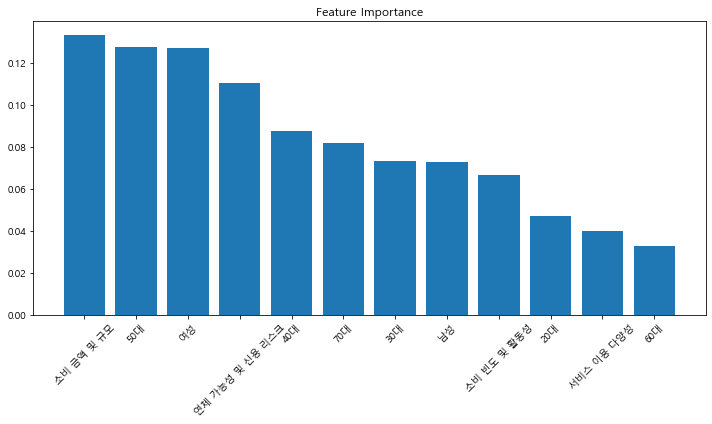

In [21]:
#  평가 함수
def evaluate_model(model, x_train, x_val, y_val):
    y_pred = model.predict(x_val)
    y_pred_proba = model.predict_proba(x_val)

    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Precision:', precision_score(y_val, y_pred))
    print('Recall:', recall_score(y_val, y_pred))
    print('F1-score:', f1_score(y_val, y_pred))
    print('ROC AUC:', roc_auc_score(y_val, y_pred_proba[:, 1]))

    # 피쳐 중요도
    feature_importance = pd.DataFrame({
        'feature': x_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xticks(rotation=45)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return y_pred, y_pred_proba
    
y_pred, y_pred_proba = evaluate_model(best_xgb_model, x_train, x_val, y_val)

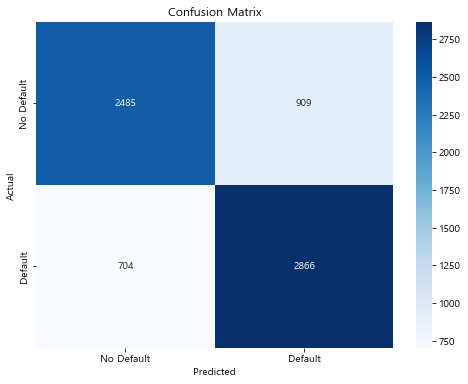

In [22]:
def confusion_mt(y_val, y_pred):
    # 혼동행렬 생성
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
  
confusion_mt(y_val, y_pred)

In [23]:
# 신용카드 예측 데이터 불러오기
predict_data = pd.read_csv('../alternative_data/credit.csv', encoding='utf-8')
predict_data.rename(columns={'회원여부_연체': '연체여부'}, inplace=True)
x_train_p, x_val_p, x_test_p, y_train_p, y_val_p, y_test_p = data_split(predict_data)

Accuracy: 0.961565
Precision: 0.009918592682698606
Recall: 0.008422056252979501
F1-score: 0.009109268250762689
ROC AUC: 0.42212869881294385


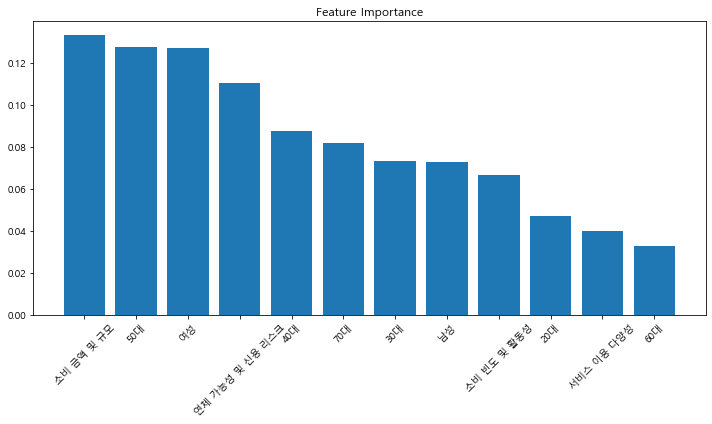

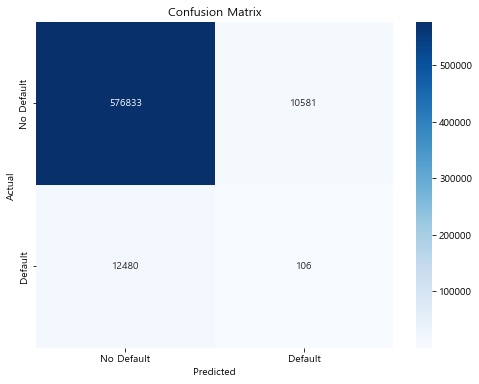

In [24]:
# XGB모델 예측
y_pred_p, y_pred_proba_p = evaluate_model(best_xgb_model, x_train_p, x_val_p, y_val_p)
confusion_mt(y_val_p, y_pred_p)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
최적의 AUC 점수: 0.8449799232077339
Accuracy: 0.7652211372774268
Precision: 0.7404921700223713
Recall: 0.8344537815126051
F1-score: 0.7846700908731727
ROC AUC: 0.8473404211419394


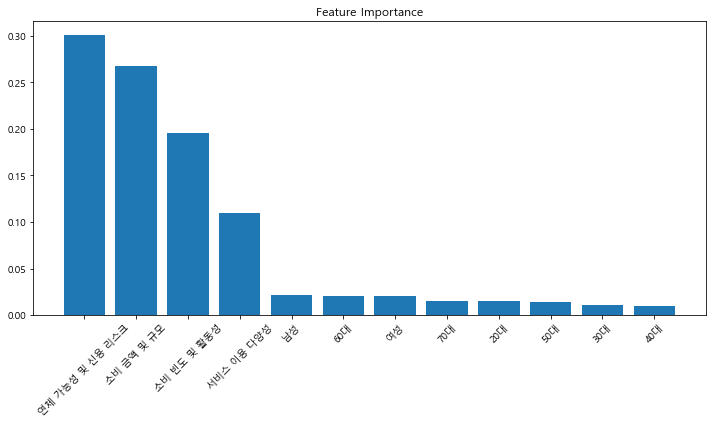

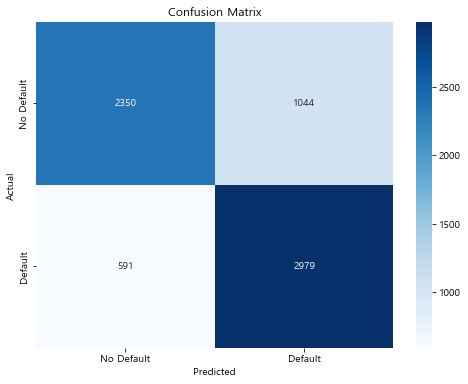

In [25]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [ 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 랜덤포레스트 모델 초기화
rf_model = RandomForestClassifier(random_state=42)

# randomSearchCV 초기화
ramdom_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_grid,
                                   scoring='roc_auc', 
                                   cv=3, 
                                   verbose=1)

# RandomizedSearchCV 실행
ramdom_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", ramdom_search.best_params_)
print("최적의 AUC 점수:", ramdom_search.best_score_)

# 최적의 하이퍼파라미터로 모델 재훈련
best_rf_model = ramdom_search.best_estimator_
best_rf_model.fit(x_train, y_train)

# 평가
y_pred_rf, y_pred_proba_rf = evaluate_model(best_rf_model, x_train, x_val, y_val)
confusion_mt(y_val, y_pred_rf)

Accuracy: 0.9477983333333333
Precision: 0.010452051215050953
Recall: 0.01589067217543302
F1-score: 0.012609942940008195
ROC AUC: 0.4787022240006559


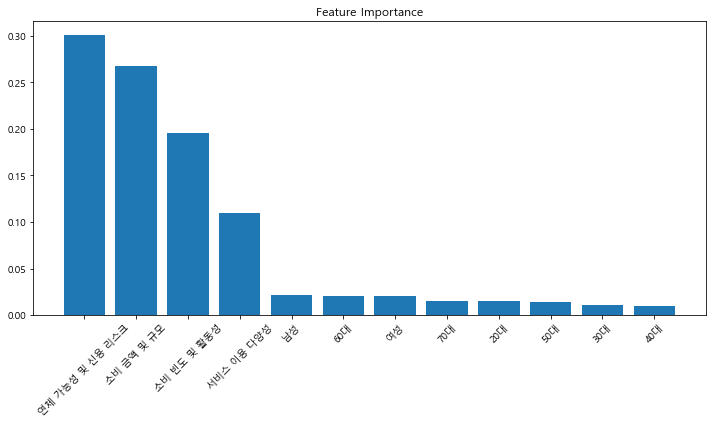

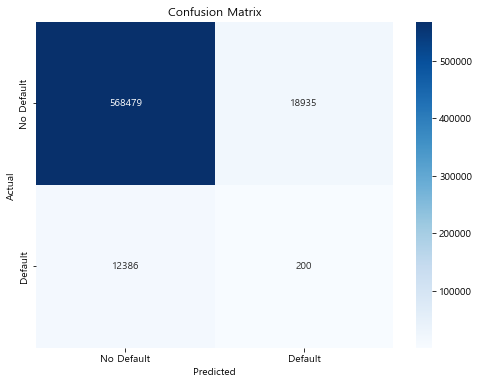

In [26]:
# 랜덤포래스트 모델 예측
y_pred_rf_p, y_pred_proba_rf_p = evaluate_model(best_rf_model, x_train_p, x_val_p, y_val_p)
confusion_mt(y_val_p, y_pred_rf_p)